In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

import librosa
import librosa.display

import os
import IPython.display as ipd

from data import get_features

c:\soft\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
N_HARM = 14
N_CAND = 100
SEQ_LEN = 16
BATCH_SIZE = 64

SR = 16000

In [3]:
filepath = 'E:/Repository/Feature_extractor/test.wav'
filepath = 'generated.wav'

signal, _, = librosa.load(filepath, sr=SR)
ipd.Audio(signal, rate=SR)

In [4]:
# signal = signal[5 * SR: 20 * SR]

In [5]:
features = get_features(signal=signal)

In [6]:
def batch_iterator(features):
    padded_features = np.pad(features, ((SEQ_LEN-1, 0), (0, 0), (0, 0)), mode='constant', constant_values=0)
    
    sequence_indicess = np.arange(SEQ_LEN)
    indices = []
    for i in range(padded_features.shape[0] - BATCH_SIZE):
        indices.append(sequence_indicess + i)
        
    indices = np.array(indices)
    full_batch = padded_features[indices]
    
    n_batches = full_batch.shape[0] // BATCH_SIZE
    last_batch_num = n_batches * BATCH_SIZE
    
    padding = ((0, full_batch.shape[0] - last_batch_num - 1), (0, 0), (0, 0), (0, 0))
    full_batch = np.pad(full_batch, padding, mode='constant', constant_values=0)

    batch_indices = np.arange(0, full_batch.shape[0]-BATCH_SIZE, BATCH_SIZE)
    for i in batch_indices:
        yield full_batch[i:i+BATCH_SIZE].astype(np.float32)

In [7]:
# mean_std = np.load('mean-std.npz')

# mean = mean_std['mean'][np.newaxis, np.newaxis, ...]
# std = mean_std['std'][np.newaxis, np.newaxis, ...]

# mean = tf.constant(mean, name='mean')
# std = tf.constant(std, name='std')

In [8]:
ckpt = tf.train.get_checkpoint_state('trained_model/new')
path_to_model = os.path.join('trained_model/new', 'model.ckpt-499999.meta')

In [9]:
sess = tf.Session()

features_phr = tf.placeholder(tf.float32, [None, SEQ_LEN, N_CAND, N_HARM], name='inputs/features')
# is_training = tf.constant(True)
model_saver = tf.train.import_meta_graph(path_to_model, input_map={'dataset/cond/Merge:0': features_phr})

outputs = [sess.graph.get_tensor_by_name(item) for item in ['Max:0',
                                                            'CNN_output/Max:0',
                                                            'RNN_output/last_rnn_output:0',
                                                            'CNN/Cond2D_2/Sigmoid:0']]

(rnn_output, cnn_output, rnn_activation, cnn_actuvation) = outputs
model_saver.restore(sess, ckpt.model_checkpoint_path)

INFO:tensorflow:Restoring parameters from trained_model/new\model.ckpt-499999


In [10]:
batch = batch_iterator(features)

results = []

for batch_features in batch:
    result = sess.run([rnn_output, cnn_output, rnn_activation, cnn_actuvation], 
                      feed_dict={features_phr: batch_features})
    results.append(result)

In [11]:
_rnn_output, _cnn_output, _rnn_activation, _cnn_actuvation = zip(*results)

In [12]:
_cnn_output = np.array(_cnn_output).reshape(np.array(_rnn_output).shape[0], -1, np.array(_rnn_output).shape[1])[:, -1, :]

In [13]:
_rnn_activation = np.array(_rnn_activation).reshape(-1, 100, 1)

In [14]:
_cnn_actuvation = np.array(_cnn_actuvation).reshape(-1, 16, 100, 1)

In [15]:
cnn_predictions = _cnn_actuvation[:, -1, :, :].max(axis=(1, 2))

In [16]:
spectrogram = librosa.feature.melspectrogram(signal, sr=SR, n_fft=512, hop_length=128)

In [17]:
_rnn_activation.shape

(192, 100, 1)

In [18]:
new_tick_locations = np.linspace(0, 1, 10)
tick_labels = ['%.2f' % f for f in np.linspace(70, 350, 10)]

In [19]:
librosa.power_to_db(spectrogram, ref=np.max).shape

(128, 251)

c:\soft\python36\lib\site-packages\librosa\display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


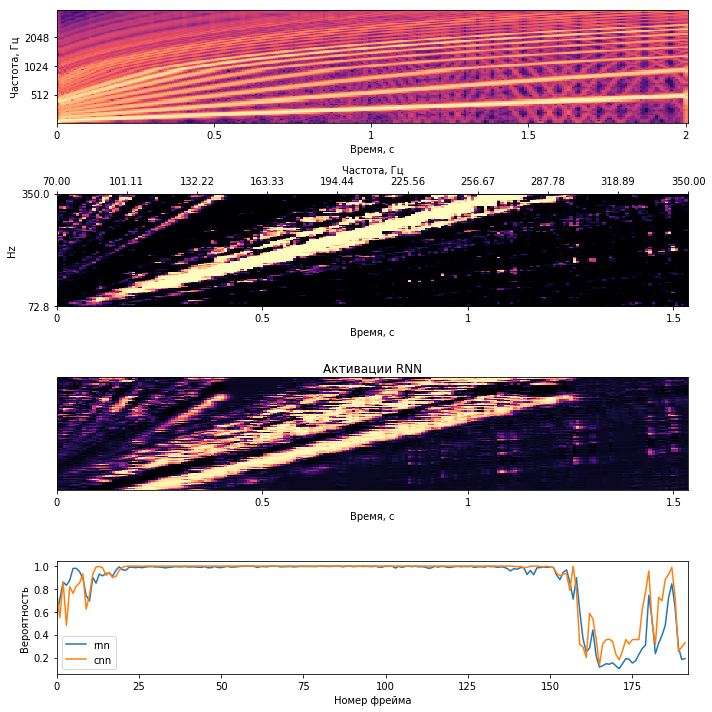

In [20]:
clip_size = 0
start_clip = 100
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max), y_axis='mel', fmax=4000, x_axis='time', sr=SR, hop_length=128)
plt.xlabel('Время, с')
plt.ylabel('Частота, Гц')

plt.subplot(4, 1, 2)
# plt.title('Активации CNN')
ax1 = librosa.display.specshow(_cnn_actuvation[:, -1, :, 0].T,  y_axis='mel', fmin=70, fmax=350, x_axis='time', sr=SR, hop_length=128)
ax1.set_xlabel('Время, с')

ax2 = ax1.twiny()
ax2.set_xticks(new_tick_locations)
ax2.set_xlabel('Частота, Гц')
ax2.set_xticklabels(tick_labels)

plt.subplot(4, 1, 3)
plt.title('Активации RNN')
# plt.imshow(_rnn_activation[:500, ::-1, 0].T)
librosa.display.specshow(_rnn_activation[:, :, 0].T, sr=SR, hop_length=128, y_axis='off', fmin=70, fmax=350, x_axis='time')
# plt.colorbar()
plt.xlabel('Время, с')
plt.subplot(4, 1, 4)
rnn_output_array = np.array(_rnn_output).flatten()
plt.plot(rnn_output_array, label='rnn')
# plt.plot((rnn_output_array[start_clip:clip_size] > 0.5).astype(np.float32), label='rnn')

# cnn_output_array = np.array(_cnn_output).reshape(107, 128, 16, -1)
cnn_output_array = cnn_predictions.flatten()
plt.plot(cnn_output_array, label='cnn')
# plt.plot((cnn_output_array[start_clip:clip_size] > 0.5).astype(np.float32), label='cnn')
# plt.subplots_adjust(left=0.0, right=0.0)
plt.xlim(0, len(cnn_output_array))
plt.xlabel('Номер фрейма')
plt.ylabel('Вероятность')
plt.legend()
plt.tight_layout()

plt.savefig('result.png')

In [34]:
a

In [21]:
weigths = sess.run(tf.trainable_variables()[0])

In [22]:
weigths = weigths[0, 0]

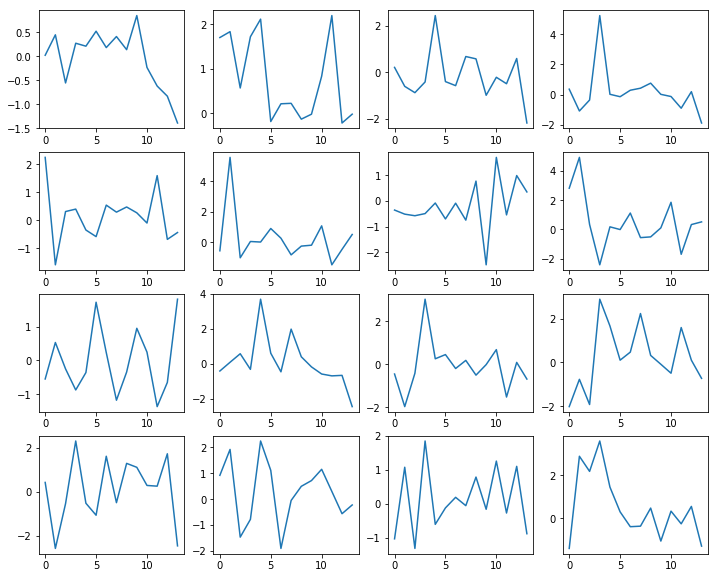

In [23]:
plt.figure(figsize=(12, 10))
for i in range(weigths.shape[-1]):
    plt.subplot(4, 4, i+1)
    plt.plot(weigths[:, i])

c:\soft\python36\lib\site-packages\librosa\display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


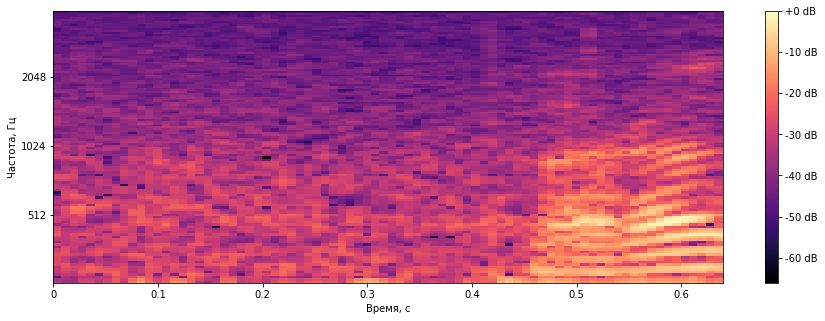

In [46]:
plt.figure(figsize=(15, 5))
librosa.display.specshow(librosa.power_to_db(spectrogram[:, start_clip+200:clip_size-270], ref=np.max), y_axis='mel', fmax=4000, x_axis='time', sr=SR, hop_length=128)
plt.xlabel('Время, с')
plt.ylabel('Частота, Гц')
plt.colorbar(format='%+2.0f dB')
plt.savefig('spectr.png')

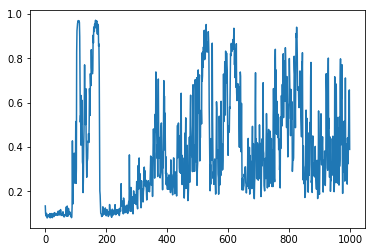

In [22]:
plt.plot(tmp[:clip_size])

In [20]:
tmp = np.array(_cnn_output).reshape(107, -1, 128)

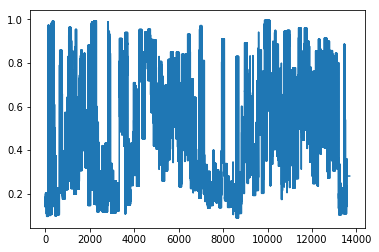

In [22]:
plt.plot(tmp[:, -1, :].flatten())

In [8]:
import itertools

def plot_confusion_matrix(classes_confusion_matrix, classes_str_to_id, normalize=False):   
    cm = classes_confusion_matrix
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    cm = np.nan_to_num(cm, copy=True)

    np.set_printoptions(precision=2)

    fig = plt.figure(figsize=(classes_confusion_matrix.shape[0]+1, classes_confusion_matrix.shape[1]+1),
                     dpi=120, facecolor='w', edgecolor='k')
    fig.clear()
    
    ax = fig.add_subplot(1, 1, 1)
    im = ax.imshow(cm, cmap='Blues')

    classes = sorted(classes_str_to_id.items(), key=lambda x: x[1])
    classes, _ = zip(*classes)

    tick_marks = np.arange(len(classes))

    ax.set_xlabel('Предсказанные', fontsize=8)
    ax.set_xticks(tick_marks)
    c = ax.set_xticklabels(classes, fontsize=10,  ha='center')
    ax.xaxis.set_label_position('bottom')
    ax.xaxis.tick_bottom()

    ax.set_ylabel('Реальные', fontsize=8)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes, fontsize=10, va ='center')
    ax.yaxis.set_label_position('left')
    ax.yaxis.tick_left()

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], '0.02f'),
                horizontalalignment="center",
                verticalalignment='center',
                fontsize=14,
                color=('black' if cm[i, j] < 0.5 else 'white'))
        
    fig.set_tight_layout(True)
    

c:\soft\python36\lib\site-packages\matplotlib\figure.py:2010: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


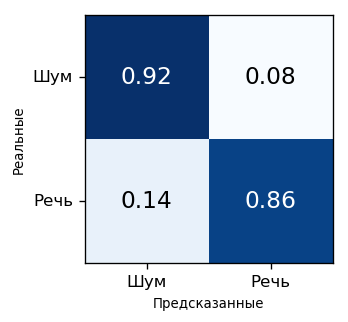

In [14]:
cm = np.array([[46, 4], [11, 67]])
plot_confusion_matrix(cm, {'Шум': 0, 'Речь': 1}, normalize=True)
plt.savefig('result.png')